In [1]:
# 12_matchup_explorer.ipynb
# 🧮 Matchup Explorer

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("cubehelix")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())



Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🎯 What You'll Explore

> **Beginner tip:** Think of each section as a question you would ask before a game: Who are we playing? How good are they lately? Take notes as you go so nothing slips through the cracks.

Game-plan upcoming opponents by comparing team and opponent tempo-free profiles. You'll:
- confirm available seasons with game-level stats
- select a matchup, filters, and window sizes
- blend season-long baselines with recent form splits
- visualize four factors, efficiency trends, and head-to-head history


In [ ]:
# 📅 Discover available seasons
team_game_seasons = sorted(p.stem for p in (DATA_DIR / 'team_game_stats').glob('*.csv'))
team_season_years = sorted(p.stem for p in (DATA_DIR / 'team_season_stats').glob('*.csv'))
print(f"Team game seasons ({len(team_game_seasons)}): {', '.join(team_game_seasons[:10])}")
print(f"Team season summaries ({len(team_season_years)}): {', '.join(team_season_years[:10])}")



## 🛠️ Set analysis parameters
Choose the two teams you want to compare. If you're new to the data, pick programs you recognize so the numbers feel grounded.

Update team names and filters, re-run the cell, then execute the rest of the notebook.


In [11]:
# 🔁 Parameters
TARGET_SEASON = 2025  # choose any season listed above
TEAM_NAME = 'Michigan'
OPPONENT_NAME = 'Ohio State'
LAST_N_GAMES = 10  # window for trend charts and recent splits
RECENT_GAMES = 5  # smaller sample for form comparison
VENUE_FILTER = None  # options: None, 'home', 'away', 'neutral'
CONFERENCE_ONLY = False  # set True to keep conference games only
METRIC_MAP = {
    'teamStats_rating': 'Offensive Rating',
    'opponentStats_rating': 'Defensive Rating Allowed',
    'pace': 'Pace',
    'teamStats_fourFactors_effectiveFieldGoalPct': 'Team eFG%',
    'opponentStats_fourFactors_effectiveFieldGoalPct': 'Opp eFG%',
    'teamStats_fourFactors_turnoverRatio': 'Team TOV%',
    'opponentStats_fourFactors_turnoverRatio': 'Opp TOV%',
    'teamStats_fourFactors_offensiveReboundPct': 'Team ORB%',
    'opponentStats_fourFactors_offensiveReboundPct': 'Opp ORB%',
    'teamStats_fourFactors_freeThrowRate': 'Team FTR',
    'opponentStats_fourFactors_freeThrowRate': 'Opp FTR'
}
HIGHLIGHT_RECENT_RUN = True  # overlay rolling average on trend chart

COMPARE_TEAMS = [TEAM_NAME, OPPONENT_NAME]
print(f"Comparing: {', '.join(COMPARE_TEAMS)}")



Comparing: Michigan, Ohio State


## 📥 Load game and season data
We pull both season summaries and game logs so you can switch between long-term trends and recent form. Verify the preview includes both teams.

Pull team game logs plus season summaries to anchor tempo-free metrics.


In [12]:
# 🗂️ Read datasets
team_games_path = DATA_DIR / 'team_game_stats' / f'{TARGET_SEASON}.csv'
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'

team_games = pd.read_csv(team_games_path)
team_season = pd.read_csv(team_season_path)

print(f"Team games loaded: {team_games.shape}")
print(f"Team season summary loaded: {team_season.shape}")

if TEAM_NAME not in team_games['team'].unique():
    available = team_games['team'].sort_values().unique()[:50]
    raise ValueError(f"TEAM_NAME '{TEAM_NAME}' not found. Examples: {', '.join(available)}")
if OPPONENT_NAME not in team_games['team'].unique():
    available = team_games['team'].sort_values().unique()[:50]
    raise ValueError(f"OPPONENT_NAME '{OPPONENT_NAME}' not found. Examples: {', '.join(available)}")



Team games loaded: (12569, 108)
Team season summary loaded: (364, 78)


/tmp/ipykernel_27326/4059334507.py:5: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  team_games = pd.read_csv(team_games_path)


## 🧹 Prep helpers
Helper functions keep the later code tidy. Skim them to understand how filters for venue, conference, and rolling windows work.

Create reusable filters for venue, conference, and rolling windows.


In [13]:
# 🧹 Helper functions
team_games['startDate'] = pd.to_datetime(team_games['startDate'])
team_games = team_games.sort_values('startDate')

def apply_filters(df, venue=None, conference_only=False):
    filtered = df.copy()
    if venue == 'home':
        filtered = filtered.loc[filtered['isHome'] == True]
    elif venue == 'away':
        filtered = filtered.loc[filtered['isHome'] == False]
    elif venue == 'neutral':
        filtered = filtered.loc[filtered['neutralSite'] == True]
    if conference_only:
        filtered = filtered.loc[filtered['conferenceGame'] == True]
    return filtered

metric_columns = list(METRIC_MAP.keys()) + [
    'teamStats_points_total', 'opponentStats_points_total'
]

def summarize_team(df, label):
    summary = {
        'label': label,
        'games': df.shape[0]
    }
    if df.empty:
        return summary
    summary['avg_margin'] = (df['teamStats_points_total'] - df['opponentStats_points_total']).mean()
    for col, friendly in METRIC_MAP.items():
        if col in df.columns:
            val = df[col].mean()
            if 'Pct' in col or col.endswith('Ratio') or col.endswith('Rate'):
                summary[friendly] = val * 100
            elif col in ['teamStats_rating', 'opponentStats_rating', 'pace']:
                summary[friendly] = val
            else:
                summary[friendly] = val
    summary['Points For'] = df['teamStats_points_total'].mean()
    summary['Points Against'] = df['opponentStats_points_total'].mean()
    return summary



## 📊 Season baselines
These metrics set the stage—how good is each team on average? Focus on net rating, pace, and the four factors to compare styles.

Compare season-long averages for each team across core efficiency metrics.


In [14]:
# 📊 Season averages
season_subset = team_season.loc[team_season['team'].isin(COMPARE_TEAMS)].copy()
season_subset = season_subset.assign(
    net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating'],
    pace=lambda df: df['pace'],
    efg=lambda df: df['teamStats_fourFactors_effectiveFieldGoalPct'] * 100,
    opp_efg=lambda df: df['opponentStats_fourFactors_effectiveFieldGoalPct'] * 100,
    turnover_rate=lambda df: df['teamStats_fourFactors_turnoverRatio'] * 100,
    opp_turnover_rate=lambda df: df['opponentStats_fourFactors_turnoverRatio'] * 100
)

keep_cols = [
    'team', 'games', 'wins', 'losses', 'pace', 'teamStats_rating', 'opponentStats_rating',
    'net_rating', 'efg', 'opp_efg', 'turnover_rate', 'opp_turnover_rate',
    'teamStats_fourFactors_offensiveReboundPct', 'opponentStats_fourFactors_offensiveReboundPct',
    'teamStats_fourFactors_freeThrowRate', 'opponentStats_fourFactors_freeThrowRate'
]

display(season_subset[keep_cols].round(2))




,team,games,wins,losses,pace,teamStats_rating,opponentStats_rating,net_rating,efg,opp_efg,turnover_rate,opp_turnover_rate,teamStats_fourFactors_offensiveReboundPct,opponentStats_fourFactors_offensiveReboundPct,teamStats_fourFactors_freeThrowRate,opponentStats_fourFactors_freeThrowRate
169,Michigan,37,27,10,67.30,113.40,104.10,9.30,5380.00,4610.00,20.00,16.00,28.80,34.70,35.70,28.40
215,Ohio State,32,17,15,65.40,114.60,106.40,8.20,5350.00,4860.00,16.00,17.00,28.30,31.10,35.80,39.90


## 🔍 Filtered game logs
Filtering the logs lets you match the context of your upcoming game. Pay attention to how many rows remain after each filter.

Apply the venue/conference filters and split into team and opponent schedules.


In [15]:
# 🔍 Filter logs
team_log = apply_filters(team_games.loc[team_games['team'] == TEAM_NAME], VENUE_FILTER, CONFERENCE_ONLY)
opponent_log = apply_filters(team_games.loc[team_games['team'] == OPPONENT_NAME], VENUE_FILTER, CONFERENCE_ONLY)

print(f"Filtered games — {TEAM_NAME}: {team_log.shape[0]} | {OPPONENT_NAME}: {opponent_log.shape[0]}")

display(team_log[['startDate', 'opponent', 'teamStats_points_total', 'opponentStats_points_total']].tail())
display(opponent_log[['startDate', 'opponent', 'teamStats_points_total', 'opponentStats_points_total']].tail())



Filtered games — Michigan: 37 | Ohio State: 32


,startDate,opponent,teamStats_points_total,opponentStats_points_total
12287,2025-03-15 23:52:00+00:00,Maryland,81.00,80.00
12322,2025-03-16 23:30:00+00:00,Wisconsin,59.00,53.00
12391,2025-03-21 06:00:00+00:00,UC San Diego,68.00,65.00
12436,2025-03-23 01:30:00+00:00,Texas A&M,91.00,79.00
12516,2025-03-29 06:00:00+00:00,Auburn,65.00,78.00


,startDate,opponent,teamStats_points_total,opponentStats_points_total
10608,2025-02-24 01:45:00+00:00,UCLA,61.00,69.00
10844,2025-02-27 08:30:00+00:00,USC,87.00,82.00
11445,2025-03-05 07:00:00+00:00,Nebraska,116.00,114.00
11773,2025-03-09 01:45:00+00:00,Indiana,60.00,66.00
12054,2025-03-13 02:00:00+00:00,Iowa,70.00,77.00


## 🔢 Summary tables
Season-long numbers sit next to recent form so you can spot hot streaks. Does the recent sample confirm or challenge the season averages?

Review season-long vs recent-form summaries side by side for both teams.


In [16]:
# 🔢 Summary comparison
recent_team = team_log.tail(RECENT_GAMES)
recent_opp = opponent_log.tail(RECENT_GAMES)

summary_rows = [
    summarize_team(team_log, f"{TEAM_NAME} — overall"),
    summarize_team(recent_team, f"{TEAM_NAME} — last {RECENT_GAMES}"),
    summarize_team(opponent_log, f"{OPPONENT_NAME} — overall"),
    summarize_team(recent_opp, f"{OPPONENT_NAME} — last {RECENT_GAMES}")
]

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index('label')

percentage_cols = [col for col in summary_df.columns if '%' in col]
summary_df[percentage_cols] = summary_df[percentage_cols].round(1)
other_cols = [col for col in summary_df.columns if col not in percentage_cols]
summary_df[other_cols] = summary_df[other_cols].round(2)

display(summary_df)



,games,avg_margin,Offensive Rating,Defensive Rating Allowed,Pace,Team eFG%,Opp eFG%,Team TOV%,Opp TOV%,Team ORB%,Opp ORB%,Team FTR,Opp FTR,Points For,Points Against
label,,,,,,,,,,,,,,,
Michigan — overall,37,6.51,109.28,102.06,70.14,5386.80,4628.10,1967.80,1559.20,2875.70,3442.40,3611.35,2883.51,77.97,71.46
Michigan — last 5,5,1.80,102.60,100.08,70.70,4592.00,4194.00,1836.00,1206.00,2990.00,3198.00,3458.00,2944.00,72.80,71.00
Ohio State — overall,32,5.28,114.23,106.24,67.41,5359.40,4865.90,1596.90,1702.80,2872.20,3030.90,3593.75,4080.00,78.81,73.53
Ohio State — last 5,5,-2.80,113.86,117.26,65.32,5108.00,5604.00,1488.00,1734.00,3442.00,2864.00,4066.00,4112.00,78.80,81.60


## 📈 Net rating trends
The line chart highlights momentum. A rising rolling average may indicate a team is peaking at the right time.

Plot game-by-game net rating and optionally overlay a rolling average.


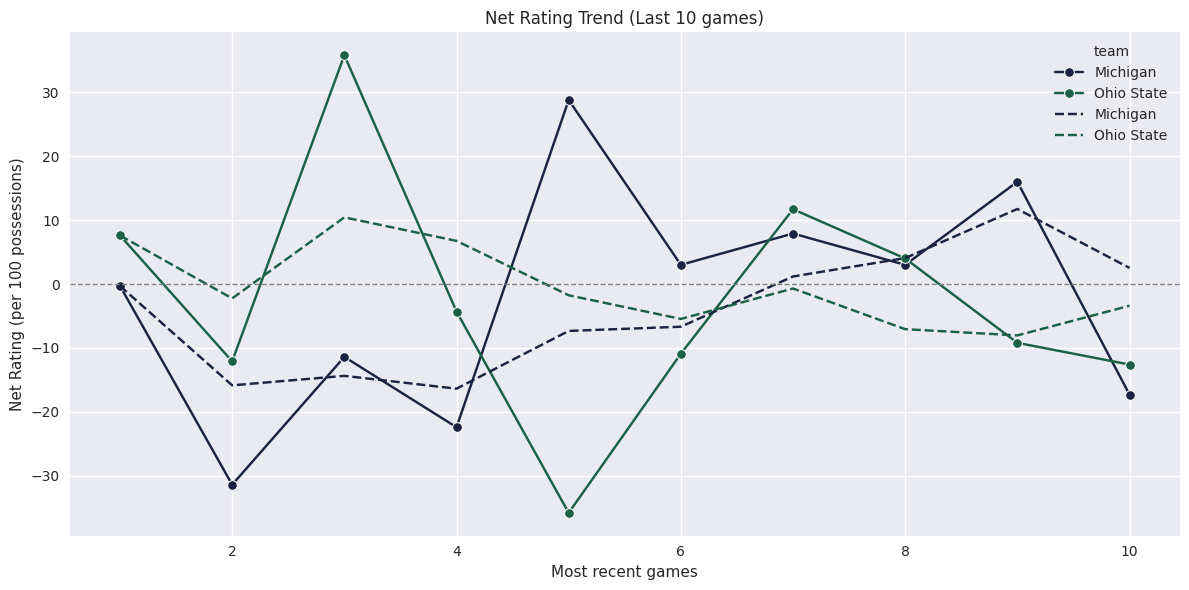

In [17]:
# 📈 Trend chart
def build_trend(df, team_label):
    trend = df.assign(
        net_rating=lambda d: d['teamStats_rating'] - d['opponentStats_rating'],
        margin=lambda d: d['teamStats_points_total'] - d['opponentStats_points_total']
    ).copy()
    trend = trend.sort_values('startDate').tail(LAST_N_GAMES)
    trend['game_number'] = range(1, trend.shape[0] + 1)
    trend['team'] = team_label
    if HIGHLIGHT_RECENT_RUN:
        trend['rolling_net'] = trend['net_rating'].rolling(window=RECENT_GAMES, min_periods=1).mean()
    return trend

trend_team = build_trend(team_log, TEAM_NAME)
trend_opp = build_trend(opponent_log, OPPONENT_NAME)
trend_data = pd.concat([trend_team, trend_opp], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x='game_number', y='net_rating', hue='team', marker='o')
if HIGHLIGHT_RECENT_RUN:
    sns.lineplot(data=trend_data.dropna(subset=['rolling_net']), x='game_number', y='rolling_net', hue='team', linestyle='--')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Net Rating Trend (Last {LAST_N_GAMES} games)')
plt.xlabel('Most recent games')
plt.ylabel('Net Rating (per 100 possessions)')
plt.tight_layout()
plt.show()



## 🔥 Four factors heatmap
Heatmaps make it easy to see which team holds the edge in shooting, turnovers, rebounding, or free throws. Bright colors signal big gaps.

Stack team vs opponent four-factor metrics to spot matchup edges.


/tmp/ipykernel_27326/1189399658.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


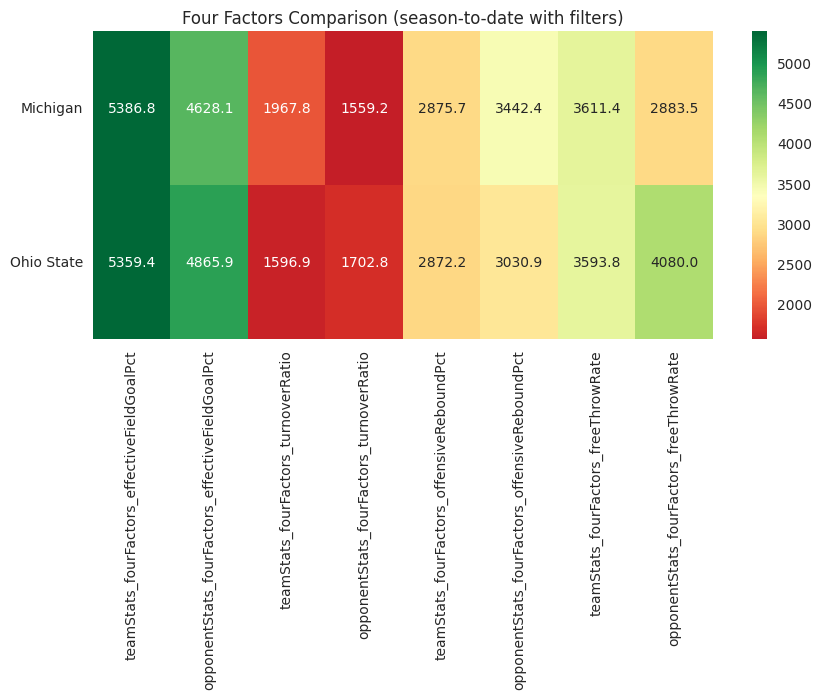

In [18]:
# 🔥 Heatmap comparison
four_factor_cols = [
    'teamStats_fourFactors_effectiveFieldGoalPct',
    'opponentStats_fourFactors_effectiveFieldGoalPct',
    'teamStats_fourFactors_turnoverRatio',
    'opponentStats_fourFactors_turnoverRatio',
    'teamStats_fourFactors_offensiveReboundPct',
    'opponentStats_fourFactors_offensiveReboundPct',
    'teamStats_fourFactors_freeThrowRate',
    'opponentStats_fourFactors_freeThrowRate'
]

heat_rows = []
for label, df in [(TEAM_NAME, team_log), (OPPONENT_NAME, opponent_log)]:
    series = df[four_factor_cols].mean()
    row = {}
    for col, value in series.items():
        if col.endswith('Pct') or col.endswith('Ratio') or col.endswith('Rate'):
            row[col] = value * 100
        else:
            row[col] = value
    heat_rows.append(row)

heat_df = pd.DataFrame(heat_rows, index=[TEAM_NAME, OPPONENT_NAME])

plt.figure(figsize=(10, 4))
sns.heatmap(heat_df, annot=True, fmt='.1f', cmap='RdYlGn', center=heat_df.values.mean())
plt.title('Four Factors Comparison (season-to-date with filters)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## 🤝 Head-to-head results
Review recent meetings for narrative context. Were the games close? Were they high scoring? Use that knowledge to frame the current matchup.

Review recent clashes between the two teams.


In [19]:
# 🤝 Head-to-head history
head_to_head = team_games.loc[
    ((team_games['team'] == TEAM_NAME) & (team_games['opponent'] == OPPONENT_NAME)) |
    ((team_games['team'] == OPPONENT_NAME) & (team_games['opponent'] == TEAM_NAME))
].copy()

if head_to_head.empty:
    print('No recorded head-to-head games in the selected dataset.')
else:
    head_to_head = head_to_head.sort_values('startDate', ascending=False)
    head_to_head['margin'] = head_to_head['teamStats_points_total'] - head_to_head['opponentStats_points_total']
    display(head_to_head[['startDate', 'team', 'opponent', 'teamStats_points_total', 'opponentStats_points_total', 'margin']].head(10))



,startDate,team,opponent,teamStats_points_total,opponentStats_points_total,margin
9909,2025-02-16 23:00:00+00:00,Michigan,Ohio State,86.00,83.00,3.00
9910,2025-02-16 23:00:00+00:00,Ohio State,Michigan,83.00,86.00,-3.00


## 🗒️ Scouting notes
Replace the placeholder bullets with your own observations. Summaries written in plain language help coaches act on the data.

Draft quick takeaways using the summary tables and charts above.


> - Replace this bullet list with your matchup notes.
> - Highlight pace mismatches, rebounding edges, or turnover risks.
> - Point out recent form trends versus season averages.


## ✅ Next steps
Connect these findings with player-level notebooks to complete your scouting packet.

- Blend player-level insights from `09_player_rate_stats.ipynb` to highlight key individual matchups.
- Layer in `team_game_stats` rolling averages (e.g., last 3/5 games) for predictive modeling.
- Export `summary_df` and `head_to_head` (via `to_csv`) for coaches or scouting reports.
